In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.metrics import silhouette_score## Loading credentials from another config file

## Loading credentials from another config file

In [2]:
import config

## Starting with Spotify API

In [3]:
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

In [4]:
#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

## Searching the song input by user

In [5]:
user_song = 'Perfect'

In [6]:
results = sp.search(q = user_song, limit = 30, market="GB")
results

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=Perfect&type=track&market=GB&offset=0&limit=30',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6eUKZXaKkcviH0Ku9w2n3V'},
       'href': 'https://api.spotify.com/v1/artists/6eUKZXaKkcviH0Ku9w2n3V',
       'id': '6eUKZXaKkcviH0Ku9w2n3V',
       'name': 'Ed Sheeran',
       'type': 'artist',
       'uri': 'spotify:artist:6eUKZXaKkcviH0Ku9w2n3V'}],
     'external_urls': {'spotify': 'https://open.spotify.com/album/3T4tUhGYeRNVUGevb0wThu'},
     'href': 'https://api.spotify.com/v1/albums/3T4tUhGYeRNVUGevb0wThu',
     'id': '3T4tUhGYeRNVUGevb0wThu',
     'images': [{'height': 640,
       'url': 'https://i.scdn.co/image/ab67616d0000b273ba5db46f4b838ef6027e6f96',
       'width': 640},
      {'height': 300,
       'url': 'https://i.scdn.co/image/ab67616d00001e02ba5db46f4b838ef6027e6f96',
       'width': 300},
      {'height': 64,
       'url': 'https://i.sc

In [7]:
for i in range(len(results['tracks']['items'])):
    print(results['tracks']['items'][i]['artists'][0]['name'])

Ed Sheeran
Ed Sheeran
Ed Sheeran
Ed Sheeran
Mareux
Ed Sheeran
One Direction
Mason
White Noise Baby Sleep
Ed Sheeran
Ed Sheeran
Jonas Blue
Ed Sheeran
Cousin Stizz
Mundo Suave
Ed Sheeran
Lou Reed
Powell Sullivan
The Beautiful South
Ed Sheeran
Ed Sheeran
Ed Sheeran
Ghost and Pals
Ed Sheeran
Ed Sheeran
Mareux
Ed Sheeran
Sam Smith
beabadoobee
SlowFez


In [8]:
# Identify artist
user_song_artist = results['tracks']['items'][0]['artists'][0]['name']

In [9]:
# Identify track ID
user_song_id = results['tracks']['items'][0]['id']

In [10]:
# Get audio features of this song
user_song_features = sp.audio_features(tracks=[user_song_id])

In [11]:
# Save the features in a dataframe
user_song_raw_df = pd.DataFrame(user_song_features)
user_song_df = user_song_raw_df[["danceability","energy","loudness","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo","duration_ms"]]
user_song_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.599,0.448,-6.312,0.0232,0.163,0,0.106,0.168,95.05,263400


## Applying Model

## Doading Dataset

In [12]:
X = pd.read_csv('data/playlists.csv')

In [13]:
X

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms
0,0.707,0.681,-4.325,0.0668,0.06320,0.000005,0.0322,0.646,117.999,0yLdNVWF3Srea0uzk55zFn,200455
1,0.644,0.735,-5.747,0.0391,0.05210,0.144000,0.1610,0.418,88.980,1Qrg8KqiBpW07V7PNxwwwL,153947
2,0.696,0.809,-8.254,0.0500,0.25200,0.000128,0.2480,0.857,132.962,6AQbmUe0Qwf5PZnt4HmTXv,131013
3,0.538,0.742,-5.355,0.1140,0.13800,0.000047,0.0934,0.250,96.107,5Z2MiIZ5I3jJvvmeWMLbOQ,272373
4,0.662,0.398,-6.691,0.0275,0.71600,0.000000,0.1110,0.468,107.001,4sx6NRwL6Ol3V6m9exwGlQ,145850
...,...,...,...,...,...,...,...,...,...,...,...
2418,0.636,0.656,-7.123,0.3440,0.02190,0.000000,0.1300,0.362,75.962,2nLwnTorexhx3qKRY7zymH,177012
2419,0.753,0.424,-10.620,0.5990,0.19700,0.000000,0.0694,0.714,162.878,5ckdswsm7RQzCTBoNiyl7T,100180
2420,0.501,0.699,-4.733,0.2480,0.17100,0.000000,0.1230,0.671,85.267,7rGzPK1JTUn91efeiIidNo,201124
2421,0.645,0.842,-3.023,0.0983,0.00816,0.000000,0.3960,0.237,150.039,2kMuUWfsueRPYWxyaTSHd8,121600


In [14]:
# Extract numerical cols
X_num = X.select_dtypes(include=['float64', 'int64'])

In [15]:
X_num

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.707,0.681,-4.325,0.0668,0.06320,0.000005,0.0322,0.646,117.999,200455
1,0.644,0.735,-5.747,0.0391,0.05210,0.144000,0.1610,0.418,88.980,153947
2,0.696,0.809,-8.254,0.0500,0.25200,0.000128,0.2480,0.857,132.962,131013
3,0.538,0.742,-5.355,0.1140,0.13800,0.000047,0.0934,0.250,96.107,272373
4,0.662,0.398,-6.691,0.0275,0.71600,0.000000,0.1110,0.468,107.001,145850
...,...,...,...,...,...,...,...,...,...,...
2418,0.636,0.656,-7.123,0.3440,0.02190,0.000000,0.1300,0.362,75.962,177012
2419,0.753,0.424,-10.620,0.5990,0.19700,0.000000,0.0694,0.714,162.878,100180
2420,0.501,0.699,-4.733,0.2480,0.17100,0.000000,0.1230,0.671,85.267,201124
2421,0.645,0.842,-3.023,0.0983,0.00816,0.000000,0.3960,0.237,150.039,121600


## Scaling features

In [16]:
scaler = StandardScaler()
scaler.fit(X_num)
X_scaled = scaler.transform(X_num)
X_scaled_df = pd.DataFrame(X_scaled, columns = X_num.columns)
display(X_num.head())
print()
display(X_scaled_df.head())

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.707,0.681,-4.325,0.0668,0.0632,0.000005,0.0322,0.646,117.999,200455
1,0.644,0.735,-5.747,0.0391,0.0521,0.144000,0.1610,0.418,88.980,153947
2,0.696,0.809,-8.254,0.0500,0.2520,0.000128,0.2480,0.857,132.962,131013
3,0.538,0.742,-5.355,0.1140,0.1380,0.000047,0.0934,0.250,96.107,272373
4,0.662,0.398,-6.691,0.0275,0.7160,0.000000,0.1110,0.468,107.001,145850


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.596043,0.433025,0.774695,-0.334403,-0.787999,-0.448685,-1.051603,0.552641,-0.025989,-0.005247
1,0.228609,0.635469,0.585278,-0.574993,-0.819821,0.002294,-0.029185,-0.365433,-1.011085,-0.778662
2,0.531888,0.912893,0.251333,-0.480320,-0.246737,-0.448300,0.661424,1.402261,0.481953,-1.160048
3,-0.389612,0.661712,0.637494,0.075556,-0.573558,-0.448555,-0.565795,-1.041908,-0.769147,1.190730
4,0.333590,-0.627934,0.459532,-0.675745,1.083483,-0.448701,-0.426086,-0.164101,-0.399334,-0.913313


# Clustering the tracks with K-Means

In [17]:
kmeans = KMeans(n_clusters = 6, random_state = 1234)
kmeans.fit(X_scaled_df)

KMeans(n_clusters=6, random_state=1234)

In [18]:
kmeans.labels_

array([5, 5, 5, ..., 3, 4, 3], dtype=int32)

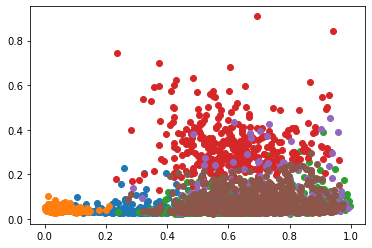

In [19]:
# assign a cluster to each example
labels = kmeans.predict(X_scaled_df)
# retrieve unique clusters
clusters = np.unique(labels)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    pyplot.scatter(X.to_numpy()[row_ix, 1], X.to_numpy()[row_ix, 3])
# show the plot
pyplot.show()

## Identify Cluster of User's Song

In [20]:
# Scale features of user song
user_scaled = scaler.transform(user_song_df)
user_scaled_df = pd.DataFrame(user_scaled, columns = user_song_df.columns)
user_scaled_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,-0.033843,-0.440486,0.510017,-0.713093,-0.501887,-0.448701,-0.465776,-1.372093,-0.805029,1.041512


In [21]:
# Get the cluster label of user song
user_cluster = kmeans.predict(user_scaled_df)

user_cluster_num = user_cluster[0]

## Choosing a Song from the Identified Cluster

In [22]:
X_clustered = pd.read_csv('data/playlists_clustered.csv')

In [23]:
X_clustered

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,cluster
0,0.707,0.681,-4.325,0.0668,0.06320,0.000005,0.0322,0.646,117.999,0yLdNVWF3Srea0uzk55zFn,200455,5
1,0.644,0.735,-5.747,0.0391,0.05210,0.144000,0.1610,0.418,88.980,1Qrg8KqiBpW07V7PNxwwwL,153947,5
2,0.696,0.809,-8.254,0.0500,0.25200,0.000128,0.2480,0.857,132.962,6AQbmUe0Qwf5PZnt4HmTXv,131013,5
3,0.538,0.742,-5.355,0.1140,0.13800,0.000047,0.0934,0.250,96.107,5Z2MiIZ5I3jJvvmeWMLbOQ,272373,2
4,0.662,0.398,-6.691,0.0275,0.71600,0.000000,0.1110,0.468,107.001,4sx6NRwL6Ol3V6m9exwGlQ,145850,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2418,0.636,0.656,-7.123,0.3440,0.02190,0.000000,0.1300,0.362,75.962,2nLwnTorexhx3qKRY7zymH,177012,3
2419,0.753,0.424,-10.620,0.5990,0.19700,0.000000,0.0694,0.714,162.878,5ckdswsm7RQzCTBoNiyl7T,100180,3
2420,0.501,0.699,-4.733,0.2480,0.17100,0.000000,0.1230,0.671,85.267,7rGzPK1JTUn91efeiIidNo,201124,3
2421,0.645,0.842,-3.023,0.0983,0.00816,0.000000,0.3960,0.237,150.039,2kMuUWfsueRPYWxyaTSHd8,121600,4


In [24]:
import random
# Filter out rows where cluster == user_cluster_num
rec_df = X_clustered[X_clustered['cluster'] == user_cluster_num]

In [25]:
rec_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,cluster
3,0.538,0.742,-5.355,0.1140,0.138000,0.000047,0.0934,0.2500,96.107,5Z2MiIZ5I3jJvvmeWMLbOQ,272373,2
9,0.714,0.472,-7.375,0.0864,0.013000,0.000005,0.2660,0.2380,131.121,3nqQXoyQOWXiESFLlDF1hG,156943,2
15,0.486,0.545,-7.924,0.0336,0.065200,0.004740,0.0642,0.0385,150.187,4FyesJzVpA39hbYvcseO2d,123891,2
16,0.559,0.551,-7.231,0.1320,0.141000,0.000000,0.1100,0.3920,143.008,4iZ4pt7kvcaH6Yo8UoZ4s2,201800,2
25,0.587,0.742,-6.640,0.0529,0.012800,0.001070,0.1460,0.1990,145.007,73vIOb4Q7YN6HeJTbscRx5,206000,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2332,0.719,0.655,-4.519,0.0999,0.202000,0.000000,0.1570,0.2380,125.925,6QC19cMrtbLNrZMH2bVl7w,233226,2
2344,0.762,0.634,-6.790,0.1260,0.073700,0.000000,0.0758,0.2080,93.127,5sm3g5UwuDnzKN91T5elip,247742,2
2386,0.834,0.730,-3.714,0.2220,0.005130,0.000000,0.1240,0.4460,155.008,2xLMifQCjDGFmkHkpNLD9h,312820,2
2403,0.729,0.625,-5.266,0.0315,0.194000,0.009860,0.2480,0.2610,146.034,1xzBco0xcoJEDXktl7Jxrr,183907,2


In [26]:
import random
# Randomly select one row from the filtered DataFrame
rec_row = rec_df.sample(random_state=1)

In [27]:
rec_id = X_clustered[X_clustered['cluster'] == user_cluster_num].sample()['id'].values[0]
rec_id

'77zu6q8jHBRPJSJRu6rsTf'

## Embeded track player

{'spotify': https://open.spotify.com/track/4O2N861eOnF9q8EtpH8IJu

In [28]:
from IPython.display import IFrame

def play_song(track_id):
    return IFrame(src="https://open.spotify.com/embed/track/"+track_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )

In [29]:
play_song(rec_id)

## Incoperating the Inputting Function

In [30]:
%pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from IPython.display import IFrame

Note: you may need to restart the kernel to use updated packages.


/Users/marcelzhang/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [31]:
# Import the dataframe of Billboard 100
hot = pd.read_csv('data/billboards_100.csv')

In [39]:
hot

,song,artist
0,Flowers,Miley Cyrus
1,Kill Bill,SZA
2,Last Night,Morgan Wallen
3,Unholy,Sam Smith & Kim Petras
4,Creepin',"Metro Boomin, The Weeknd & 21 Savage"
...,...,...
95,Yandel 150,Yandel & Feid
96,Heart To Heart,Mac DeMarco
97,Next Thing You Know,Jordan Davis
98,Never Gonna Not Dance Again,P!nk


In [32]:
# Define a function to find the ID of a song
def find_track_id(song, artist):
    results = sp.search(q = song, limit = 30, market="GB")
    for i in range(len(results['tracks']['items'])):
        if results['tracks']['items'][i]['artists'][0]['name'] == artist:
            track_id = results["tracks"]["items"][i]["id"]
    return track_id

In [33]:
# for i in range(len(results['tracks']['items'])):
#     if results['tracks']['items'][i]['artists'][0]['name'] == 'Ed Sheeran':
#         track_id = results["tracks"]["items"][i]["id"]

In [34]:
play_song(find_track_id('Flowers', 'Miley Cyrus'))

In [35]:
# def GrooveGenie():
#     while True:
#         input_song = input('Please enter a hot song: ')
#         match_ratios = [fuzz.token_set_ratio(input_song.lower(), s.lower()) for s in hot.song] # Generate a list of matching scores
#         max_ratio = max(match_ratios) # Get the highest matching score
#         if max_ratio >= 70:
#             input_song = hot.song[match_ratios.index(max_ratio)] # Correct the input by the song which matches the input best
#             check_singer = hot.loc[hot.song.str.lower() == input_song.lower(), 'artist'][0]
#             comfirm = input(f'Do you mean "{input_song}" performed by "{check_singer}"? (Y/N) ')
#             if comfirm.lower() == 'y':
#                 print(f'Got it! Playing "{input_song}"!')
#                 play_song(find_track_id(input_song)) # Play the song
#                 break
#             else:
#                 rec_hot = random.sample(hot.song.tolist(), k=5)
#                 print(f'Sorry, this is not a hot song. Would you like to try one of these hot songs? {rec_hot}')
#         else:
#             rec_hot = random.sample(hot.song.tolist(), k=5)
#             print(f'Sorry, this is not a hot song. Would you like to try one of these hot songs? {rec_hot}')

In [36]:
# # Update find_track_id() (two arguemnets)

# def GrooveGenie():
#     while True:
#         input_song = input('Please enter a hot song: ')
#         match_ratios = [fuzz.token_set_ratio(input_song.lower(), s.lower()) for s in hot.song] # Generate a list of matching scores
#         max_ratio = max(match_ratios) # Get the highest matching score
#         if max_ratio >= 70:
#             input_song = hot.song[match_ratios.index(max_ratio)] # Correct the input by the song which matches the input best
#             check_singer = hot.loc[hot.song.str.lower() == input_song.lower(), 'artist'][0]
#             comfirm = input(f'Do you mean "{input_song}" performed by "{check_singer}"? (Y/N) ')
#             if comfirm.lower() == 'y':
#                 print(f'Got it! Playing "{input_song}" performed by "{check_singer}"!')
#                 display(play_song(find_track_id(input_song, check_singer))) # Play the song
#                 break
#             else:
#                 rec_hot = random.sample(hot.song.tolist(), k=1)
#                 print(f'Sorry, this is not a hot song. Would you like to try one of these hot songs? {rec_hot}')
#         else:
#             rec_hot = random.sample(hot.song.tolist(), k=5)
#             print(f'Sorry, this is not a hot song. Would you like to try one of these hot songs? {rec_hot}')

In [37]:
# Recommend another hot song and play it

def GrooveGenie():
    while True:
        input_song = input('Please enter a hot song: ')
        match_ratios = [fuzz.token_set_ratio(input_song.lower(), s.lower()) for s in hot.song] # Generate a list of matching scores
        max_ratio = max(match_ratios) # Get the highest matching score
        if max_ratio >= 70:
            input_song = hot.song[match_ratios.index(max_ratio)] # Correct the input by the song which matches the input best
            check_singer = hot.loc[hot.song.str.lower() == input_song.lower(), 'artist'][0]
            comfirm = input(f'Do you mean "{input_song}" performed by "{check_singer}"? (Y/N) ')
            if comfirm.lower() == 'y':
                print(f'Got it! Playing "{input_song}" performed by "{check_singer}"!')
                display(play_song(find_track_id(input_song, check_singer))) # Play the song
                
                rec_hot = random.sample(hot.song.tolist(), k=1)[0]
                rec_hot_request = input(f'Would you like to try another hot song: "{rec_hot}"? (Y/N)')
                if rec_hot_request.lower() == 'y':
                    rec_hot_singer = hot.loc[hot.song.str.lower() == rec_hot.lower(), 'artist'].iloc[0]
                    print(f'Wonderful! Playing "{rec_hot}" performed by "{rec_hot_singer}!')
                    display(play_song(find_track_id(rec_hot, rec_hot_singer)))
                    print(f'Thank you for using GrooveGenie!')
                    break
                else:
                    print(f'Thank you for using GrooveGenie!')
                    break
            else:
                rec_hot = random.sample(hot.song.tolist(), k=1)
                print(f'Sorry, this is not a hot song. Would you like to try one of these hot songs? {rec_hot}')
        else:
            rec_hot = random.sample(hot.song.tolist(), k=5)
            print(f'Sorry, this is not a hot song. Would you like to try one of these hot songs? {rec_hot}')

In [38]:
GrooveGenie()

Please enter a hot song: flowers
Do you mean "Flowers" performed by "Miley Cyrus"? (Y/N) y
Got it! Playing "Flowers" performed by "Miley Cyrus"!


Would you like to try another hot song: "Tomorrow 2"? (Y/N)y
Wonderful! Playing "Tomorrow 2" performed by "GloRilla & Cardi B!


UnboundLocalError: local variable 'track_id' referenced before assignment